In [1]:
import csv
import ast
import random
import statistics as st
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
react_records = []
with open('reaction.csv', newline='') as react_csv:
    csv_reader = csv.reader(react_csv, delimiter=';')
    for row in csv_reader:
        react_records.append({'id': row[0], 'visitor': row[1], 'typ': row[2], 'date': row[3], 'data': ast.literal_eval(row[4])})
        
react_humans = []
react_h_mouse = []
react_h_touchpad = []
react_h_trackball = []
react_bots = []
react_b_gc = []  # ghost-cursor
no_input_type = 0
idx = 0
while idx < len(react_records):
    record = react_records[idx]
    if record['visitor'] == 'human':
        if record['data']['positions'][0]['x'] == 0 or record['id'] == '68':  # id 68-as valószínűleg az első gomb megjelenése után váltott teljes képernyőre
            react_records.remove(record)
        else:
            react_humans.append(record)
            idx += 1
            if record['typ'] == 'mouse':
                react_h_mouse.append(record)
            elif record['typ'] == 'touchpad':
                react_h_touchpad.append(record)
            elif record['typ'] == 'trackball':
                react_h_trackball.append(record)
            else:
                no_input_type += 1
    else:
        react_bots.append(record)
        idx += 1
        if record['typ'] == 'ghost-cursor':
            react_b_gc.append(record)
            
def check_data(data_list):
    not_valid_idxs = []
    for idx, data in enumerate(data_list):
        last_click_time = data['data']['buttonData'][-1]['click']['time']
        if last_click_time/20 > len(data['data']['positions']) + 2:
            not_valid_idxs.append(idx)
    return not_valid_idxs

bad_h_idxs = check_data(react_humans)
bad_humans = [react_humans[badidx] for badidx in bad_h_idxs]
react_humans = [react_humans[idx] for idx, human in enumerate(react_humans) if idx not in bad_h_idxs]

bad_b_idxs = check_data(react_bots)
bad_bots = [react_bots[badidx] for badidx in bad_b_idxs]
react_bots = [react_bots[idx] for idx, bot in enumerate(react_bots) if idx not in bad_b_idxs]

print('Adatok száma:')
print('\tEmberek:')
print('\t\tJó adatok száma:', len(react_humans))
print('\t\tRossz adatok száma:', len(bad_humans))
print('\t\tegér (összesből):', len(react_h_mouse))
print('\t\térintőpárna (összesből):', len(react_h_touchpad))
print('\t\ttrackball (összesből):', len(react_h_trackball))
print('\t\tnincs megadva beviteli eszköz (összesből):', no_input_type)
print('\tBotok:')
print('\t\tJó adatok száma:', len(react_bots))
print('\t\tRossz adatok száma:', len(bad_bots))
print('\t\tghost-cursor (összesből):', len(react_b_gc))
print('\t------------------------------------')
print('\tÖsszesen:', len(react_records))

Adatok száma:
	Emberek:
		Jó adatok száma: 48
		Rossz adatok száma: 27
		egér (összesből): 38
		érintőpárna (összesből): 9
		trackball (összesből): 0
		nincs megadva beviteli eszköz (összesből): 28
	Botok:
		Jó adatok száma: 76
		Rossz adatok száma: 1
		ghost-cursor (összesből): 77
	------------------------------------
	Összesen: 152


In [3]:
# ember csoportoknak megfelelő számosságú adatsorok a botokból

react_bots_48 = random.sample(react_bots, 48)
react_bots_27 = [bot for bot in react_bots if bot not in react_bots_48][:-1]

In [4]:
# egérmozgás animálása

def animate_path(toanim, save_with=''):
    thisx = np.array([pos['x'] for pos in toanim['data']['positions']])
    thisy = np.array([pos['y'] for pos in toanim['data']['positions']])
    buttondim = [toanim['data']['buttonDimensions']['width'], toanim['data']['buttonDimensions']['height']]
    viewport = toanim['data']['viewport']
    fig, ax = plt.subplots()
    fig.set_size_inches((viewport['width']/viewport['height']*6, 6))
    fig.set_tight_layout(True)
    ax.set_aspect('equal')
    
    buttons = toanim['data']['buttonData']
    appeartimes = [button['appeared'] for button in buttons]
    clicktimes = [button['click']['time'] for button in buttons]
    clickposes = [{'x': button['click']['x'], 'y': button['click']['y']} for button in buttons]

    ax.set_xlim((0, viewport['width']))
    ax.set_ylim((-viewport['height'], 0))
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    path, = ax.plot([], [], lw=3, color='r', zorder=1)
    cursor, = ax.plot([], [], 'o', markersize=6, color='r', zorder=1)


    def animate(frame):
        if len(appeartimes) and frame > appeartimes[0]/20:
            ax.add_patch((Rectangle((buttons[len(buttons)-len(appeartimes)]['buttonX'], \
                                     -buttons[len(buttons)-len(appeartimes)]['buttonY']),\
                                      buttondim[0], -buttondim[1], color='0.8', zorder=0)))
            appeartimes.pop(0)
        
        if len(clicktimes) and frame > clicktimes[0]/20:
            ax.plot(clickposes[len(clickposes)-len(clicktimes)]['x'], -clickposes[len(clickposes)-len(clicktimes)]['y'], \
                    'o', markersize=9, color='b', zorder=2)
            clicktimes.pop(0)
        
        if frame < len(thisx):
            pathx = []
            pathy = []
            if frame < 6:
                linecount = frame
            else:
                linecount = 6
            for i in range(linecount):
                pathx.append(thisx[frame-i])
                pathy.append(-thisy[frame-i])
                path.set_data(pathx, pathy)

            cursorx = pathx[0] if pathx else thisx[0]
            cursory = pathy[0] if pathy else -thisy[0]
            cursor.set_data(cursorx, cursory)
        else:
            path.set_data([], [])
            
        return path, cursor
        
        
    framenum = max(len(thisx), int(max(clicktimes)/20)) + 50
    ani = animation.FuncAnimation(fig, animate, frames=framenum, interval=20, blit=True)
    plt.close()
    display(HTML(ani.to_html5_video()))
    
    ax.clear()
    ax.set_xlim((0, viewport['width']))
    ax.set_ylim((-viewport['height'], 0))
    
    appeartimes = [button['appeared'] for button in buttons]
    clicktimes = [button['click']['time'] for button in buttons]
    
    path, = ax.plot([], [], lw=3, color='r', zorder=1)
    cursor, = ax.plot([], [], 'o', markersize=6, color='r', zorder=1)
        
    if save_with:
        ani.save(save_with,'ffmpeg')

# 1. Mousemove eventek

Mousemove eventek:

	Emberek:
		max: 2160
		min: 332
		átlag: 691.8125
		medián: 568.5
		korrigált tapasztalati szórás: 351.24245467779815
		kvantilisek: [482.  568.5 790. ]
	-----------------------------------------------------
	Botok:
		max: 938
		min: 558
		átlag: 713.0625
		medián: 710.0
		korrigált tapasztalati szórás: 79.1062862310992
		kvantilisek: [646.   710.   752.75]


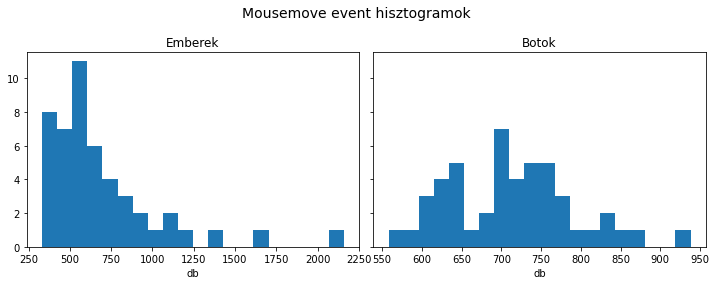

In [5]:
def print_stats(data_array, print_mean=True, num_of_tabs=0):
    print(num_of_tabs*'\t' + f'max: {np.amax(data_array)}')
    print(num_of_tabs*'\t' + f'min: {np.amin(data_array)}')
    if print_mean:
        print(num_of_tabs*'\t' + f'átlag: {np.mean(data_array)}')
    print(num_of_tabs*'\t' + f'medián: {np.median(data_array)}')
    print(num_of_tabs*'\t' + f'korrigált tapasztalati szórás: {np.std(data_array, ddof=1)}')
    print(num_of_tabs*'\t' + f'kvantilisek: {np.quantile(data_array, [0.25, 0.5, 0.75])}')
    
def print_h_and_b(h_data_array, b_data_array, title, print_mean=True, before_h='', before_b='', after_h='', after_b=''):
    print(title +'\n')
    print('\tEmberek:')
    if before_h:
        print(before_h)
    print_stats(h_data_array, print_mean=print_mean, num_of_tabs=2)
    if after_h:
        print(after_h)
    print('\t-----------------------------------------------------')
    print('\tBotok:')
    if before_h:
        print(before_b)
    print_stats(b_data_array, print_mean=print_mean, num_of_tabs=2)
    if after_b:
        print(after_b)
        
def h_and_b_hist(h_data_array, b_data_array, title, xlabel='', bins=20):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    fig.suptitle(title, fontsize=14)
    fig.set_figwidth(10)
    
    if xlabel:
        axs[0].set_xlabel(xlabel)
        axs[1].set_xlabel(xlabel)

    mm_ev_hist_h = axs[0]
    mm_ev_hist_h.hist(h_data_array, bins=bins)
    mm_ev_hist_h.set_title('Emberek')

    mm_ev_hist_b = axs[1]
    mm_ev_hist_b.hist(b_data_array, bins=bins)
    mm_ev_hist_b.set_title('Botok')

mm_events_h = [human['data']['mouseMoveEvents'] for human in react_humans]
mm_events_b = [bot['data']['mouseMoveEvents'] for bot in react_bots_48]

print_h_and_b(mm_events_h, mm_events_b, 'Mousemove eventek:')
h_and_b_hist(mm_events_h, mm_events_b, 'Mousemove event hisztogramok', 'db')

Mousemove eventek a kiugró adatok eltávolítása után:

	Emberek:
		eltávolított adatok száma: 2
		max: 1379
		min: 332
		átlag: 638.6304347826087
		medián: 560.5
		korrigált tapasztalati szórás: 238.32380947830455
		kvantilisek: [480.   560.5  762.25]
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 938
		min: 558
		átlag: 713.0625
		medián: 710.0
		korrigált tapasztalati szórás: 79.1062862310992
		kvantilisek: [646.   710.   752.75]


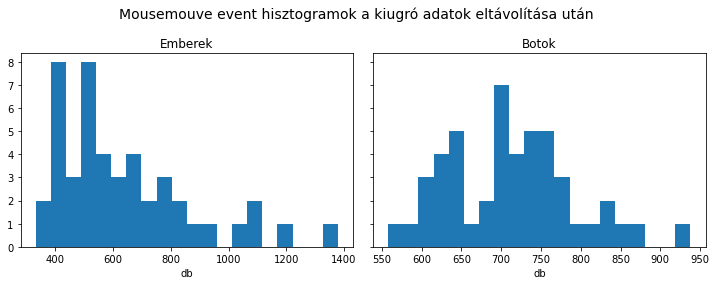

In [6]:
# mousemove event adatsorok kiugró értékeinek eltávolítása

mm_events_h_corr = [mm_event for mm_event in mm_events_h if mm_event < 1500]
mm_events_b_corr = mm_events_b

print_h_and_b(mm_events_h_corr, mm_events_b_corr, 'Mousemove eventek a kiugró adatok eltávolítása után:',\
            before_h=f'\t\teltávolított adatok száma: {len(mm_events_h) - len(mm_events_h_corr)}',\
            before_b=f'\t\teltávolított adatok száma: {len(mm_events_b) - len(mm_events_b_corr)}')

h_and_b_hist(mm_events_h_corr, mm_events_b_corr, 'Mousemouve event hisztogramok a kiugró adatok eltávolítása után', 'db')

# 2. Sebességek

## 2.1. Max sebességek

Max sebességek (vp%/s)

	Emberek:
		max: 3024.2832455505154
		min: 504.75132767264654
		átlag: 1040.8762079776943
		medián: 971.5793392227152
		korrigált tapasztalati szórás: 431.1156818288514
		kvantilisek: [ 749.70601006  971.57933922 1215.68669054]
	-----------------------------------------------------
	Botok:
		max: 1135.7294396745292
		min: 331.9440923257106
		átlag: 634.584405796495
		medián: 590.7864902851077
		korrigált tapasztalati szórás: 216.93741247167924
		kvantilisek: [482.46244843 590.78649029 750.93896366]


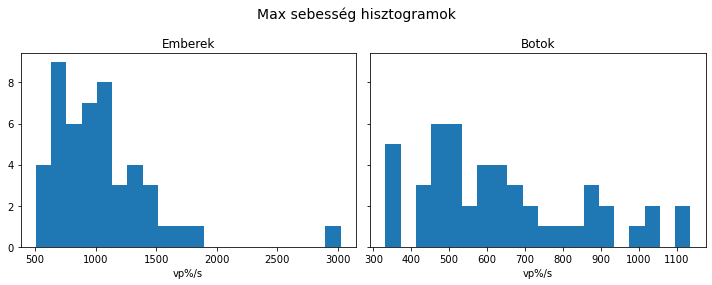

In [7]:
def norm_pos(pos, viewport):
    return {'x': pos['x']/viewport['width'] * 100, 'y': pos['y']/viewport['height'] * 100}

def calculate_distance(pos1, pos2, normed=True, viewport={}):
    if normed:
        pos1_normed = norm_pos(pos1, viewport)
        pos2_normed = norm_pos(pos2, viewport)
        return ((pos1_normed['x'] - pos2_normed['x'])**2 + (pos1_normed['y'] - pos2_normed['y'])**2)**0.5
    else:
        return ((pos1['x'] - pos2['x'])**2 + (pos1['y'] - pos2['y'])**2)**0.5


def calculate_vel(poslist, normed=True, viewport={}, timediv=0.02):
    i = 0
    vel_list = []
    while i < len(poslist) - 1:
        vel_list.append(calculate_distance(poslist[i], poslist[i + 1], normed=normed, viewport=viewport)/timediv)
        i += 1
    return vel_list


human_vels = [calculate_vel(human['data']['positions'], viewport=human['data']['viewport']) for human in react_humans]
bot_vels = [calculate_vel(bot['data']['positions'], viewport=bot['data']['viewport']) for bot in react_bots_48]

max_h_vels = [max(human_vel) for human_vel in human_vels]
max_b_vels = [max(bot_vel) for bot_vel in bot_vels]

print_h_and_b(max_h_vels, max_b_vels, 'Max sebességek (vp%/s)')
h_and_b_hist(max_h_vels, max_b_vels, 'Max sebesség hisztogramok', 'vp%/s')

Max sebességek a kiugró adatok eltávolítása után (vp%/s)

	Emberek:
		eltávolított adatok száma: 1
		max: 1888.7509036395697
		min: 504.75132767264654
		átlag: 998.6760582421025
		medián: 962.4179756497458
		korrigált tapasztalati szórás: 320.2529846419624
		kvantilisek: [ 749.41202012  962.41797565 1207.80118287]
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 1135.7294396745292
		min: 331.9440923257106
		átlag: 634.584405796495
		medián: 590.7864902851077
		korrigált tapasztalati szórás: 216.93741247167924
		kvantilisek: [482.46244843 590.78649029 750.93896366]


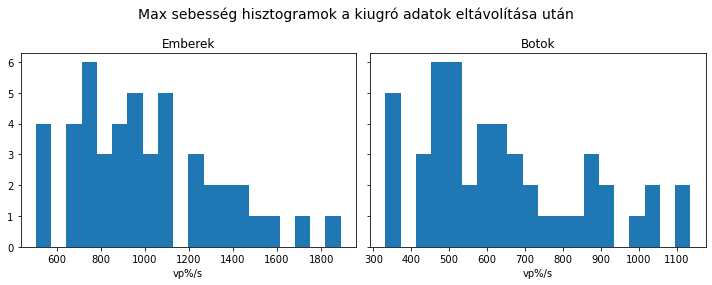

In [8]:
# max sebesség adatsorok kiugró értékeinek eltávolítása

max_h_vels_corr = [max_vel for max_vel in max_h_vels if max_vel < 2000]
max_b_vels_corr = max_b_vels

print_h_and_b(max_h_vels_corr, max_b_vels_corr, 'Max sebességek a kiugró adatok eltávolítása után (vp%/s)',\
            before_h=f'\t\teltávolított adatok száma: {len(max_h_vels) - len(max_h_vels_corr)}',\
            before_b=f'\t\teltávolított adatok száma: {len(max_b_vels) - len(max_b_vels_corr)}')

h_and_b_hist(max_h_vels_corr, max_b_vels_corr, 'Max sebesség hisztogramok a kiugró adatok eltávolítása után', 'vp%/s')

## 2.2. Átlag sebességek

Átlag sebességek (vp%/s)

	Emberek:
		max: 109.18882183900601
		min: 12.367064336982864
		medián: 22.51958067818257
		korrigált tapasztalati szórás: 14.168300408246651
		kvantilisek: [18.35254642 22.51958068 27.14351359]
		Az összes emberre számolt átlag sebesség: 24.906288409521697
	-----------------------------------------------------
	Botok:
		max: 18.330122783799393
		min: 15.454955733104539
		medián: 16.970532743703224
		korrigált tapasztalati szórás: 0.7532600977880484
		kvantilisek: [16.4941132  16.97053274 17.56920941]
		Az összes botra számolt átlag sebesség: 16.924566801661474


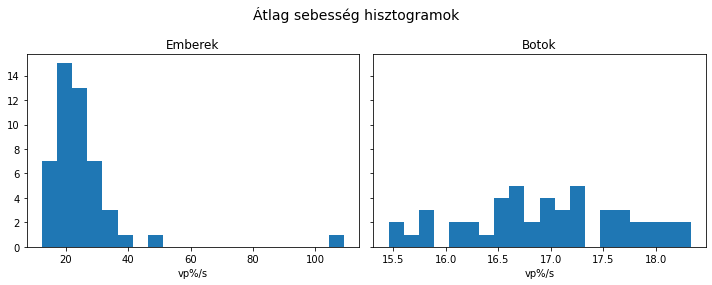

In [9]:
avg_h_vels = [st.mean(human_vel) for human_vel in human_vels]
avg_b_vels = [st.mean(bot_vel) for bot_vel in bot_vels]

h_vel_num = 0
avg_h_vel_all = 0
for all_vels, avg_vel in zip(human_vels, avg_h_vels):
    h_vel_num += len(all_vels)
    avg_h_vel_all += avg_vel * len(all_vels)
avg_h_vel_all /= h_vel_num

b_vel_num = 0
avg_b_vel_all = 0
for all_vels, avg_vel in zip(bot_vels, avg_b_vels):
    b_vel_num += len(all_vels)
    avg_b_vel_all += avg_vel * len(all_vels)
avg_b_vel_all /= b_vel_num
    

print_h_and_b(avg_h_vels, avg_b_vels, 'Átlag sebességek (vp%/s)', print_mean=False,\
            after_h=f'\t\tAz összes emberre számolt átlag sebesség: {avg_h_vel_all}',\
            after_b=f'\t\tAz összes botra számolt átlag sebesség: {avg_b_vel_all}')

h_and_b_hist(avg_h_vels, avg_b_vels, 'Átlag sebesség hisztogramok', 'vp%/s')

Átlag sebességek a kiugró adatok eltávolítása után (vp%/s)

	Emberek:
		eltávolított adatok száma: 1
		max: 48.74005558062276
		min: 12.367064336982864
		medián: 22.384721006612132
		korrigált tapasztalati szórás: 7.020927278775972
		kvantilisek: [18.27729728 22.38472101 26.80387133]
		Az összes emberre számolt átlag sebesség: 23.38975843437146
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 18.330122783799393
		min: 15.454955733104539
		medián: 16.970532743703224
		korrigált tapasztalati szórás: 0.7532600977880484
		kvantilisek: [16.4941132  16.97053274 17.56920941]
		Az összes botra számolt átlag sebesség: 16.924566801661474


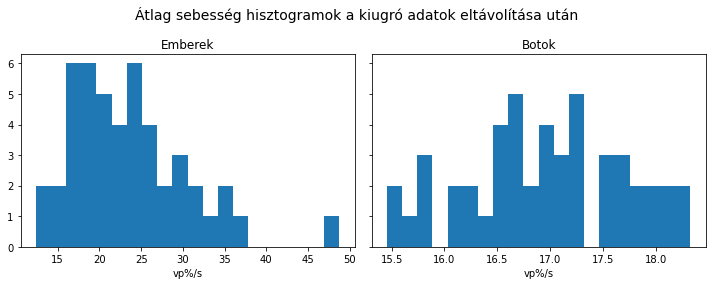

In [10]:
# átlag sebesség adatsorok kiugró értékeinek eltávolítása

avg_h_vels_corr = [avg_vel for avg_vel in avg_h_vels if avg_vel < 60]
avg_b_vels_corr = avg_b_vels

h_vel_num = 0
avg_h_vel_all_corr = 0
for all_vels, avg_vel in zip(human_vels, avg_h_vels_corr):
    h_vel_num += len(all_vels)
    avg_h_vel_all_corr += avg_vel * len(all_vels)
avg_h_vel_all_corr /= h_vel_num

b_vel_num = 0
avg_b_vel_all_corr = 0
for all_vels, avg_vel in zip(bot_vels, avg_b_vels_corr):
    b_vel_num += len(all_vels)
    avg_b_vel_all_corr += avg_vel * len(all_vels)
avg_b_vel_all_corr /= b_vel_num

print_h_and_b(avg_h_vels_corr, avg_b_vels_corr, 'Átlag sebességek a kiugró adatok eltávolítása után (vp%/s)',\
            print_mean=False,\
            before_h=f'\t\teltávolított adatok száma: {len(avg_h_vels) - len(avg_h_vels_corr)}',\
            after_h=f'\t\tAz összes emberre számolt átlag sebesség: {avg_h_vel_all_corr}',\
            before_b=f'\t\teltávolított adatok száma: {len(avg_b_vels) - len(avg_b_vels_corr)}',\
            after_b=f'\t\tAz összes botra számolt átlag sebesség: {avg_b_vel_all_corr}')

h_and_b_hist(avg_h_vels_corr, avg_b_vels_corr, 'Átlag sebesség hisztogramok a kiugró adatok eltávolítása után', 'vp%/s')

# 3. Kattintások átlagos távolsága a gombok középpontjától

A kattintások távolsága a gombok kp-jától (button%)

	Emberek:
		max: 41.69173920996272
		min: 20.0016045083712
		átlag: 29.617139669143125
		medián: 29.021812913225197
		korrigált tapasztalati szórás: 4.873027501154759
		kvantilisek: [25.81664134 29.02181291 32.94280046]
	-----------------------------------------------------
	Botok:
		max: 49.28365261922938
		min: 25.98185904537901
		átlag: 38.41293950196562
		medián: 38.25682017654621
		korrigált tapasztalati szórás: 3.8693572815598847
		kvantilisek: [35.8199497  38.25682018 41.06766342]


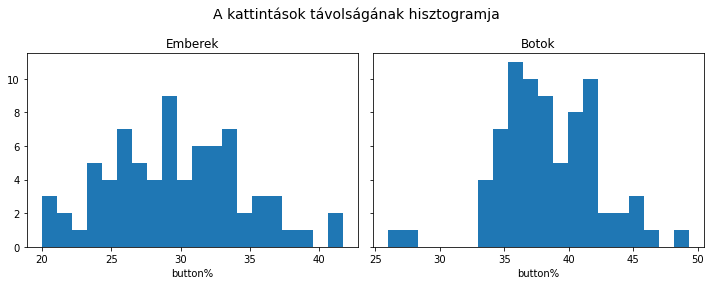

In [11]:
dist_per_h = []
for human in react_humans+bad_humans:
    buttons_h = [button for button in human['data']['buttonData']]
    buttondims_h = human['data']['buttonDimensions']

    dist_per_click = []
    for button in buttons_h:
        center = {'x': button['buttonX'] + buttondims_h['width']/2, 'y': button['buttonY'] + buttondims_h['height']/2}
        dist_per_click.append(calculate_distance({'x': button['click']['x'], 'y':button['click']['y']}, \
                                                 center, viewport=buttondims_h))
    dist_per_h.append(st.mean(dist_per_click))
    
dist_per_b = []
for bot in react_bots_48+react_bots_27:
    buttons_b = [button for button in bot['data']['buttonData']]
    buttondims_b = bot['data']['buttonDimensions']

    dist_per_click = []
    for button in buttons_b:
        center = {'x': button['buttonX'] + buttondims_b['width']/2, 'y': button['buttonY'] + buttondims_b['height']/2}
        dist_per_click.append(calculate_distance({'x': button['click']['x'], 'y':button['click']['y']}, \
                                                 center, viewport=buttondims_b))
    dist_per_b.append(st.mean(dist_per_click))
    
print_h_and_b(dist_per_h, dist_per_b, 'A kattintások távolsága a gombok kp-jától (button%)')

h_and_b_hist(dist_per_h, dist_per_b, 'A kattintások távolságának hisztogramja', 'button%')

# 4. Mozgás gombok megjelenése között

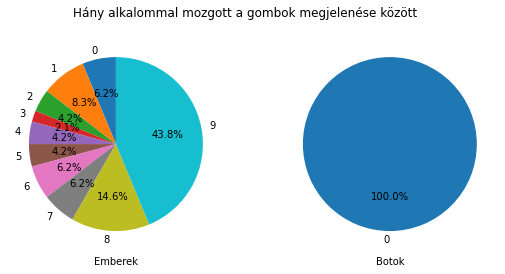

In [12]:
num_of_motion_h = []
for human in react_humans:
    num_for_this = 0
    buttons = human['data']['buttonData']
    positions = human['data']['positions']
    i = 0
    intervals = []
    while i < len(buttons) - 1:
        intervals.append((int(buttons[i]['click']['time']/20), int(buttons[i+1]['appeared']/20)))
        i += 1
    for interval in intervals:
        for vel in calculate_vel(positions[interval[0]:interval[1]], normed=False):
            if vel != 0:
                num_for_this += 1
                break
    num_of_motion_h.append(num_for_this)
    
counted_h = []
for i in range(0, 10):
    counted_h.append(num_of_motion_h.count(i))
    
num_of_motion_b = []
for bot in react_bots_48:
    num_for_this = 0
    buttons = bot['data']['buttonData']
    positions = bot['data']['positions']
    i = 0
    intervals = []
    while i < len(buttons) - 1:
        intervals.append((int(buttons[i]['click']['time']/20), int(buttons[i+1]['appeared']/20)))
        i += 1
    for interval in intervals:
        for vel in calculate_vel(positions[interval[0]:interval[1]], normed=False):
            if vel != 0:
                num_for_this += 1
                break
    num_of_motion_b.append(num_for_this)
    
counted_b = []
for i in range(0, 10):
    counted_b.append(num_of_motion_b.count(i))
    
bot_labels = []
i = 0
while i < len(counted_b):
    if counted_b[i] == 0:
        counted_b.pop(i)
    else:
        bot_labels.append(str(i))
        i += 1


labels = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
fig.suptitle('Hány alkalommal mozgott a gombok megjelenése között')
ax1.pie(counted_h,labels=labels, startangle=90, autopct='%1.1f%%')
ax1.set_xlabel('Emberek')
ax2.pie(counted_b,labels=bot_labels, startangle=90, autopct='%1.1f%%')
ax2.set_xlabel('Botok')
None

# 5. Reakcióidő

A reakcióidők (ms)

	Emberek:
		max: 708
		min: 250
		átlag: 400.0425531914894
		medián: 380.0
		korrigált tapasztalati szórás: 106.4579846591477
		kvantilisek: [331. 380. 455.]
	-----------------------------------------------------
	Botok:
		max: 346
		min: 210
		átlag: 255.5744680851064
		medián: 256.0
		korrigált tapasztalati szórás: 36.59397947682168
		kvantilisek: [224. 256. 277.]


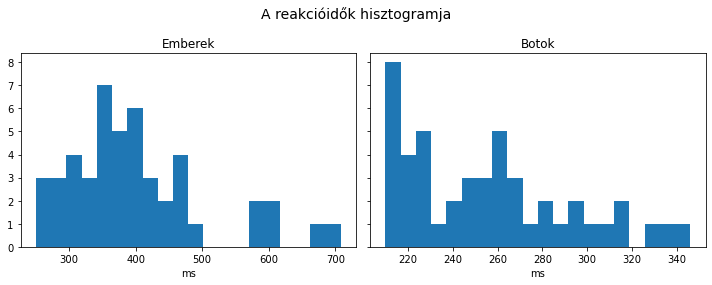

In [13]:
all_reaction_h = []
for human in react_humans:
    if human['id'] != '70':  # folyamatosan mozgatta a kurzort
        this_reaction = []
        buttons = human['data']['buttonData']
        positions = human['data']['positions']
        appear_times = [button['appeared'] for button in buttons]
        intervals = [(int(button['appeared']/20), int(button['click']['time']/20)) for button in buttons]
        vel_per_interval = [calculate_vel(positions[interval[0]:interval[1]], normed=False) for interval in intervals]
        for this_inter_vel in vel_per_interval:
            i = 7  # 150 ms körül van a legkisebb lehetséges reakcióidő
            while i < len(this_inter_vel):
                if this_inter_vel[i] > max(this_inter_vel)*0.1:
                    this_reaction.append(i*20)
                    break
                i += 1
        all_reaction_h.append(this_reaction)
avg_reaction_h = [st.mean(this_react) for this_react in all_reaction_h]

all_reaction_b = []
for bot in react_bots_48[:-1]:  # hogy ugyanannyi adatot ábrázoljunk
    this_reaction = []
    buttons = bot['data']['buttonData']
    positions = bot['data']['positions']
    appear_times = [button['appeared'] for button in buttons]
    intervals = [(int(button['appeared']/20), int(button['click']['time']/20)) for button in buttons]
    vel_per_interval = [calculate_vel(positions[interval[0]:interval[1]], normed=False) for interval in intervals]
    for this_inter_vel in vel_per_interval:
        i = 0  # itt mindegy a minimum, mert úgysem mozog a gomb megjelenése előtt
        while i < len(this_inter_vel):
            if this_inter_vel[i] > min(this_inter_vel):  # a sebességben is mindegy a minimum
                this_reaction.append(i*20)
                break
            i += 1
    all_reaction_b.append(this_reaction)
avg_reaction_b = [st.mean(this_react) for this_react in all_reaction_b]

print_h_and_b(avg_reaction_h, avg_reaction_b, 'A reakcióidők (ms)')

h_and_b_hist(avg_reaction_h, avg_reaction_b, 'A reakcióidők hisztogramja', 'ms')

A reakcióidők a kiugró adatok eltávolítása után (ms)

	Emberek:
		eltávolított adatok száma: 2
		max: 596
		min: 250
		átlag: 387.1111111111111
		medián: 376.0
		korrigált tapasztalati szórás: 88.40974396684354
		kvantilisek: [326. 376. 428.]
	-----------------------------------------------------
	Botok:

		max: 316
		min: 210
		átlag: 250.04545454545453
		medián: 249.0
		korrigált tapasztalati szórás: 30.622954261396146
		kvantilisek: [222.  249.  266.5]


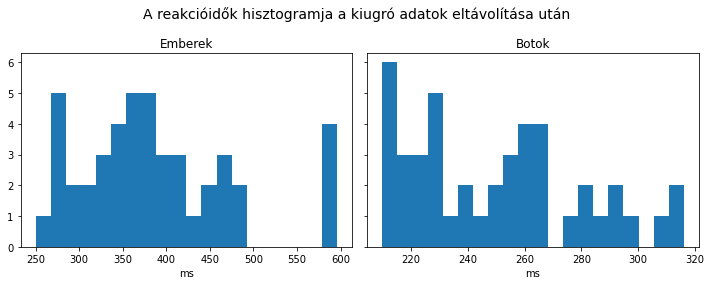

In [14]:
# reakcióidőkből a kiugró adatok eltávolítása

avg_react_h_corr = [this_avg for this_avg in avg_reaction_h if this_avg < 650]
avg_react_b_corr = [this_avg for this_avg in avg_reaction_b if this_avg < 320]

print_h_and_b(avg_react_h_corr, avg_react_b_corr, 'A reakcióidők a kiugró adatok eltávolítása után (ms)', \
             before_h=f'\t\teltávolított adatok száma: {len(avg_reaction_h) - len(avg_react_h_corr)}')

h_and_b_hist(avg_react_h_corr, avg_react_b_corr, 'A reakcióidők hisztogramja a kiugró adatok eltávolítása után', 'ms')

# 6. Finompozicionálás

A finompozicionálás ideje (ms)

	Emberek:
		max: 1442
		min: 294
		átlag: 613.5416666666666
		medián: 546.0
		korrigált tapasztalati szórás: 227.13956327701644
		kvantilisek: [487. 546. 655.]
	-----------------------------------------------------
	Botok:
		max: 556
		min: 198
		átlag: 397.4166666666667
		medián: 407.0
		korrigált tapasztalati szórás: 87.85186597113308
		kvantilisek: [327.  407.  466.5]


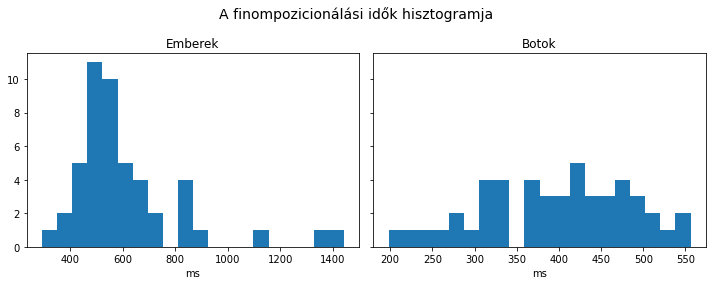

In [15]:
avg_fine_per_h = []
for human in react_humans:
    buttondim = human['data']['buttonDimensions']
    buttons = human['data']['buttonData']
    positions = human['data']['positions']
    this_h_fine = []
    for button in buttons:
        appear_time = button['appeared']
        click_time = button['click']['time']
        area = {
            'xl': button['buttonX'] - 2 * buttondim['height'],
            'xu': button['buttonX'] + buttondim['width'] + 2 * buttondim['height'],
            'yl': button['buttonY'] - 2 * buttondim['height'],
            'yu': button['buttonY'] + buttondim['height'] + 2 * buttondim['height']
        }
        pos_num = 0
        for pos in positions[int(appear_time/20):int(click_time/20)]:
            if (area['xl'] <= pos['x'] <= area['xu']) and (area['yl'] <= pos['y'] <= area['yu']):
                pos_num += 1
        this_h_fine.append((pos_num - 1) * 20)
    avg_fine_per_h.append(st.mean(this_h_fine))
    
avg_fine_per_b = []
for bot in react_bots_48:
    buttondim = bot['data']['buttonDimensions']
    buttons = bot['data']['buttonData']
    positions = bot['data']['positions']
    this_b_fine = []
    for button in buttons:
        appear_time = button['appeared']
        click_time = button['click']['time']
        area = {
            'xl': button['buttonX'] - 2 * buttondim['height'],
            'xu': button['buttonX'] + buttondim['width'] + 2 * buttondim['height'],
            'yl': button['buttonY'] - 2 * buttondim['height'],
            'yu': button['buttonY'] + buttondim['height'] + 2 * buttondim['height']
        }
        pos_num = 0
        for pos in positions[int(appear_time/20):int(click_time/20)]:
            if (area['xl'] <= pos['x'] <= area['xu']) and (area['yl'] <= pos['y'] <= area['yu']):
                pos_num += 1
        this_b_fine.append((pos_num - 1) * 20)
    avg_fine_per_b.append(st.mean(this_b_fine))
    
print_h_and_b(avg_fine_per_h, avg_fine_per_b, 'A finompozicionálás ideje (ms)')

h_and_b_hist(avg_fine_per_h, avg_fine_per_b, 'A finompozicionálási idők hisztogramja', 'ms')

A finompozicionálás ideje a kiugró adatok eltávolítása után (ms)

	Emberek:
		eltávolított adatok száma: 3
		max: 922
		min: 294
		átlag: 566.9777777777778
		medián: 546.0
		korrigált tapasztalati szórás: 135.68588204326412
		kvantilisek: [484. 546. 608.]
	-----------------------------------------------------
	Botok:
		eltávolított adatok száma: 0
		max: 556
		min: 198
		átlag: 397.4166666666667
		medián: 407.0
		korrigált tapasztalati szórás: 87.85186597113308
		kvantilisek: [327.  407.  466.5]


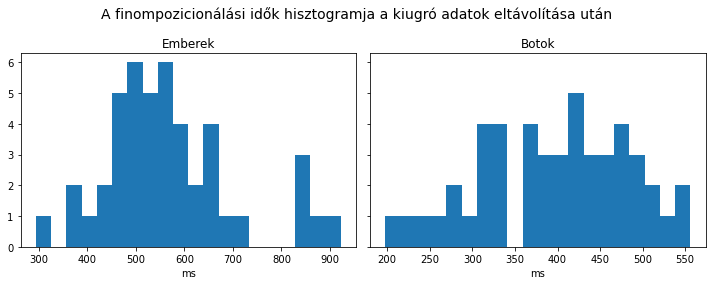

In [16]:
# finompozicionálási időkből a kiugró adatok eltávolítása

avg_fine_per_h_corr = [this_fine for this_fine in avg_fine_per_h if this_fine < 1000]
avg_fine_per_b_corr = avg_fine_per_b

print_h_and_b(avg_fine_per_h_corr, avg_fine_per_b_corr, 'A finompozicionálás ideje a kiugró adatok eltávolítása után (ms)', \
             before_h=f'\t\teltávolított adatok száma: {len(avg_fine_per_h) - len(avg_fine_per_h_corr)}', \
             before_b=f'\t\teltávolított adatok száma: {len(avg_fine_per_b) - len(avg_fine_per_b_corr)}')

h_and_b_hist(avg_fine_per_h_corr, avg_fine_per_b_corr, 'A finompozicionálási idők hisztogramja a kiugró adatok eltávolítása után', 'ms')

# 5. Egyéb grafikus ábrázolások

In [17]:
def plot_vel(to_plot):
    time = [idx*0.02 for idx, pos in enumerate(to_plot['data']['positions'])][:-1]
    plt.plot(time, calculate_vel(to_plot['data']['positions'], viewport=to_plot['data']['viewport']))
    plt.xlabel('idő (s)')
    plt.ylabel('sebesség (vp%/s)')